ModuleNotFoundError: No module named 'ucimlrepo'

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve

# Load car evaluation dataset
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df = pd.read_csv('car.data', header=None, names=col_names)

# Display basic information about the dataset
df_info = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [2]:
# Explore unique values in feature columns and the label column
for feature in df.columns[:-1]:
    unique_vals = df[feature].unique()
    print(f"{feature}: {len(unique_vals)} values, {unique_vals}")

buying: 4 values, ['vhigh' 'high' 'med' 'low']
maint: 4 values, ['vhigh' 'high' 'med' 'low']
doors: 4 values, ['2' '3' '4' '5more']
persons: 3 values, ['2' '4' 'more']
lug_boot: 3 values, ['small' 'med' 'big']
safety: 3 values, ['low' 'med' 'high']


In [3]:
label_name = df.columns[-1]
label_unique_vals = df[label_name].unique()
print(f"{label_name}: {len(label_unique_vals)} values, {label_unique_vals}")

class: 4 values, ['unacc' 'acc' 'vgood' 'good']


In [4]:
# Display total counts for each unique value in the label column
label_value_counts = df[label_name].value_counts()
print(label_value_counts)

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


In [5]:
# Encode ordinal data and create dummy columns
ordinal_mapping = {
    'buying': {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3},
    'maint': {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2},
}

df_mapped = df.replace(ordinal_mapping)
print(df_mapped)

      buying  maint  doors  persons  lug_boot  safety  class
0          3      3      0        0         0       0  unacc
1          3      3      0        0         0       1  unacc
2          3      3      0        0         0       2  unacc
3          3      3      0        0         1       0  unacc
4          3      3      0        0         1       1  unacc
...      ...    ...    ...      ...       ...     ...    ...
1723       0      0      3        2         1       1   good
1724       0      0      3        2         1       2  vgood
1725       0      0      3        2         2       0  unacc
1726       0      0      3        2         2       1   good
1727       0      0      3        2         2       2  vgood

[1728 rows x 7 columns]


In [6]:
df_encoded_mapped = pd.get_dummies(df_mapped, columns=col_names[:-1], drop_first=True)
df_encoded_mapped['class'], class_uniques_mapped = pd.factorize(df_encoded_mapped['class'])
class_col_mapped = df_encoded_mapped['class']
df_encoded_mapped.drop(columns=['class'], inplace=True)
last_col_pos_mapped = df_encoded_mapped.columns.get_loc('safety_2') + 1
df_encoded_mapped.insert(last_col_pos_mapped, 'class', class_col_mapped)
print(df_encoded_mapped)

      buying_1  buying_2  buying_3  maint_1  maint_2  maint_3  doors_1  \
0            0         0         1        0        0        1        0   
1            0         0         1        0        0        1        0   
2            0         0         1        0        0        1        0   
3            0         0         1        0        0        1        0   
4            0         0         1        0        0        1        0   
...        ...       ...       ...      ...      ...      ...      ...   
1723         0         0         0        0        0        0        0   
1724         0         0         0        0        0        0        0   
1725         0         0         0        0        0        0        0   
1726         0         0         0        0        0        0        0   
1727         0         0         0        0        0        0        0   

      doors_2  doors_3  persons_1  persons_2  lug_boot_1  lug_boot_2  \
0           0        0          0      

In [7]:
# Split data into features (X) and labels (y)
X_mapped = df_encoded_mapped.loc[:, 'buying_1':'safety_2']
y_mapped = df_encoded_mapped['class']
#print(X_mapped)
#print(y_mapped)

# Split data into training and test sets
X_train_mapped, X_test_mapped, y_train_mapped, y_test_mapped = train_test_split(X_mapped, y_mapped, test_size=0.25, random_state=42)

In [8]:
# Create and train a random forest classifier with ordinality
clf_mapped = DecisionTreeClassifier(random_state=42)
clf_mapped.fit(X_train_mapped, y_train_mapped)

DecisionTreeClassifier(random_state=42)

In [9]:
# Predictions on the test set
y_pred_mapped = clf_mapped.predict(X_test_mapped)
y_pred_mapped[0:5]

array([0, 3, 0, 1, 0], dtype=int64)

In [10]:
class_uniques_mapped

Index(['unacc', 'acc', 'vgood', 'good'], dtype='object')

In [11]:
# Evaluate the model
accuracy_mapped = accuracy_score(y_test_mapped, y_pred_mapped)
conf_matrix_mapped = confusion_matrix(y_test_mapped, y_pred_mapped)
class_report_mapped = classification_report(y_test_mapped, y_pred_mapped)

In [12]:
# Feature selection using importance-based selection
feature_selector = SelectFromModel(clf_mapped, prefit=True)
X_train_selected = feature_selector.transform(X_train_mapped)
X_test_selected = feature_selector.transform(X_test_mapped)

In [13]:
# Create and train a new decision tree classifier with selected features
clf_selected = DecisionTreeClassifier(random_state=42)
clf_selected.fit(X_train_selected, y_train_mapped)

DecisionTreeClassifier(random_state=42)

In [14]:
# Predictions on the test set with selected features
y_pred_selected = clf_selected.predict(X_test_selected)

In [15]:
# Evaluate the model with selected features
accuracy_selected = accuracy_score(y_test_mapped, y_pred_selected)

In [16]:
# Display results
print("Original Dataset Information:")
print(df_info)
print("\nEncoded Dataset Information:")
print(df_encoded_mapped.info())
print("\nOrdinality Leveraging Model Accuracy:")
print(f"Accuracy: {accuracy_mapped:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_mapped)
print("\nClassification Report:")
print(class_report_mapped)
print("\nFeature Selection Model Accuracy:")
print(f"Accuracy with selected features: {accuracy_selected:.4f}")

Original Dataset Information:
None

Encoded Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   buying_1    1728 non-null   uint8
 1   buying_2    1728 non-null   uint8
 2   buying_3    1728 non-null   uint8
 3   maint_1     1728 non-null   uint8
 4   maint_2     1728 non-null   uint8
 5   maint_3     1728 non-null   uint8
 6   doors_1     1728 non-null   uint8
 7   doors_2     1728 non-null   uint8
 8   doors_3     1728 non-null   uint8
 9   persons_1   1728 non-null   uint8
 10  persons_2   1728 non-null   uint8
 11  lug_boot_1  1728 non-null   uint8
 12  lug_boot_2  1728 non-null   uint8
 13  safety_1    1728 non-null   uint8
 14  safety_2    1728 non-null   uint8
 15  class       1728 non-null   int64
dtypes: int64(1), uint8(15)
memory usage: 38.9 KB
None

Ordinality Leveraging Model Accuracy:
Accuracy: 0.9444

Confusion Matr

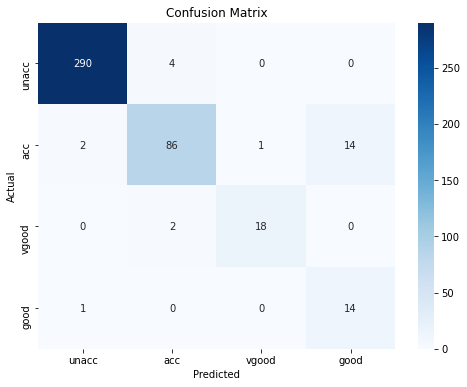

In [17]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mapped, annot=True, fmt='d', cmap='Blues', xticklabels=class_uniques_mapped, yticklabels=class_uniques_mapped)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Note: you may need to restart the kernel to use updated packages.


In [21]:
#pip install graphviz pydotplus

Note: you may need to restart the kernel to use updated packages.


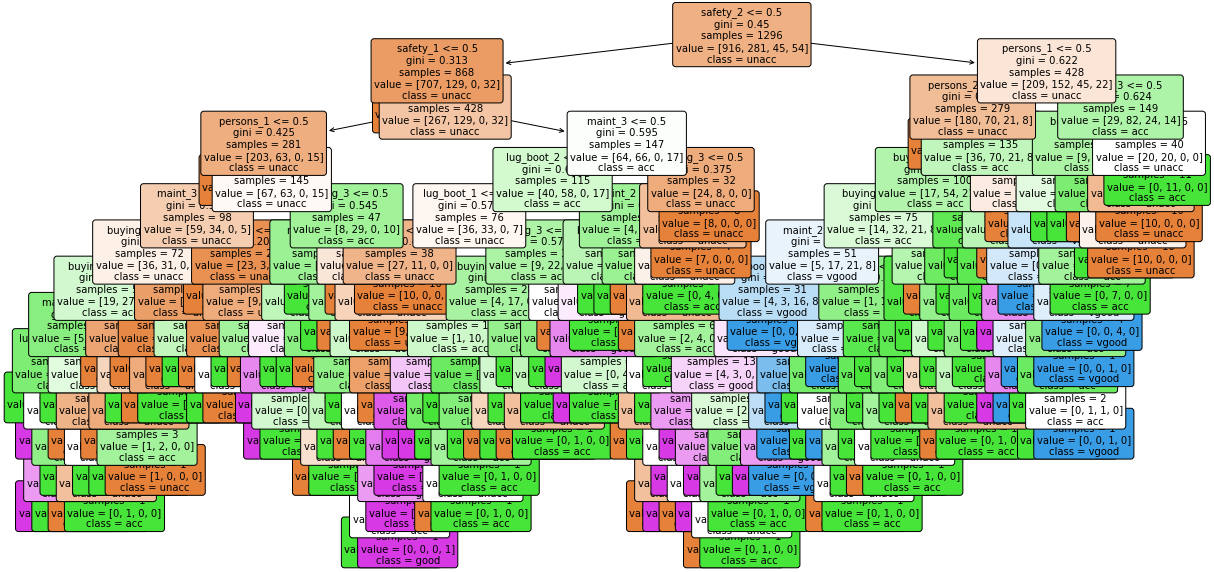

In [47]:
# Display the decision tree (requires graphviz and pydotplus)
import numpy as np
from sklearn.tree import plot_tree
#from sklearn.tree import export_graphviz
#import graphviz
#from io import StringIO
#import pydotplus

# dot_data = StringIO()
# export_graphviz(clf_mapped, out_file=dot_data, feature_names=X_mapped.columns, class_names=class_uniques_mapped, filled=True, rounded=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('decision_tree.png')
# Image(graph.create_png())

# Visualize the decision tree without GraphViz
plt.figure(figsize=(20,10))
plot_tree(clf_mapped, feature_names=X_mapped.columns, class_names=class_uniques_mapped, filled=True, rounded=True, fontsize=10)
plt.show()

Note: you may need to restart the kernel to use updated packages.


In [26]:
# K-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(clf_mapped, X_mapped, y_mapped, cv=cv, scoring='accuracy')

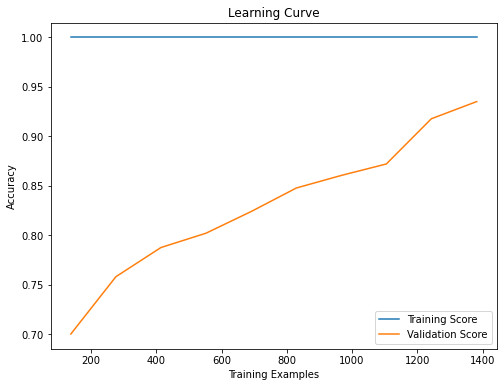

In [27]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(clf_mapped, X_mapped, y_mapped, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Feature Importance
feature_importance = clf_mapped.feature_importances_
feature_names = X_mapped.columns
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
df_importance = df_importance.sort_values(by='Importance', ascending=False)

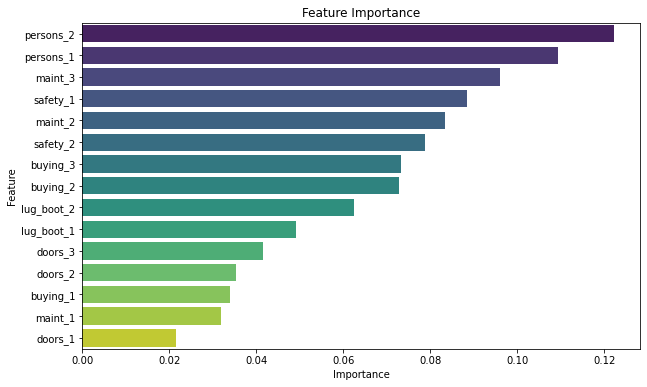

In [29]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')
plt.title('Feature Importance')
plt.show()

In [35]:
df_proba.duplicated('Confidence').any()

True

In [36]:
df_proba = df_proba.drop_duplicates('Confidence')

In [37]:
df_proba.duplicated('Confidence').any()

False

In [43]:
df_proba['Confidence'].var()

0.0

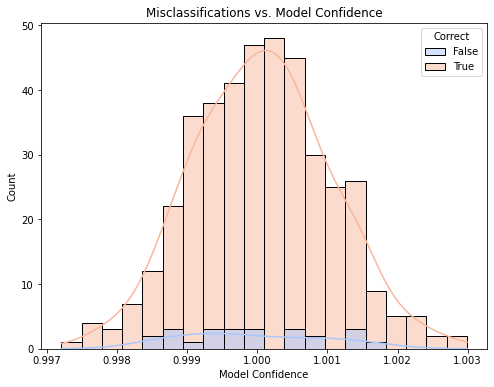

In [44]:
# Plot misclassifications vs. model confidence
proba_correct = clf_mapped.predict_proba(X_test_mapped).max(axis=1)
df_proba = pd.DataFrame({'Correct': (y_pred_mapped == y_test_mapped), 'Confidence': proba_correct})

df_proba['Confidence'] += np.random.normal(0, 0.001, size=len(df_proba))

plt.figure(figsize=(8, 6))
sns.histplot(data=df_proba, x='Confidence', hue='Correct', bins=20, kde=True, palette='coolwarm')
plt.title('Misclassifications vs. Model Confidence')
plt.xlabel('Model Confidence')
plt.ylabel('Count')
plt.show()